In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Train

In [2]:
train = pd.read_csv("./train_data_withlabels.csv")
train = train.iloc[:, 1:]

# change type from string to datetime object
train.localminute = pd.to_datetime(train.localminute)

# create new columns
train['month'] = train.localminute.dt.month
train['date'] = train.localminute.dt.day
train['weekday'] = train.localminute.dt.weekday
train['hour'] = train.localminute.dt.hour
train['minute'] = train.localminute.dt.minute

# remove localminute column
train = train.iloc[:, 1:]

# move target column just for ease
target = train.pop('target')
train['target'] = target

# get column names
col_names = train.columns.to_list()

target = train.target
feature_a = train.iloc[:,0:7].columns.to_list()
feature_b = train.iloc[:,7:-1].columns.to_list()
normal_standard = ColumnTransformer([('standardscaler', StandardScaler(), feature_a)], 
                                    remainder='passthrough')
normal_minmax = ColumnTransformer([('minmaxscaler', MinMaxScaler(), feature_b)], 
                                  remainder='passthrough')

# use sklearn to normalize data
#pipe_me = Pipeline([("standard", normal_standard), ("minmax", normal_minmax)]).fit(train.drop('target', axis = 1))
train_normal = pd.DataFrame(normal_standard.fit_transform(train))
# rename columns
train_normal.columns = col_names
# do the rest
train_normal = pd.DataFrame(normal_minmax.fit_transform(train_normal))

# rename columns
train_normal.columns = feature_b + feature_a + ["target"]

In [3]:
train_f = train_normal.drop('month', axis = 1)

# convert dates to categorical
train_f['date'] = train_f['date'].astype('category')
train_f['weekday'] = train_f['weekday'].astype('category')
train_f['hour'] = train_f['hour'].astype('category')
train_f['minute'] = train_f['minute'].astype('category')

targ = train_f.target
train_f = train_f.drop('target', axis = 1)
train_f['target'] = targ

train_f = pd.get_dummies(train_f)

# split to train and validation
validation_x, train_x = train_test_split(train_f, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.drop('target', axis = 1)

validation_y = validation_x.target
validation_x = validation_x.drop('target', axis = 1)

#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     2108.
Date:                Mon, 06 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:50:30   Log-Likelihood:             1.2469e+05
No. Observations:              377828   AIC:                        -2.491e+05
Df Residuals:                  377702   BIC:                        -2.478e+05
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
total_load        

In [4]:
lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)

val_y = lr_model.predict(validation_x)
pred_y = lr_model.predict(train_x)

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    357305
         1.0       0.84      0.75      0.79     20523

    accuracy                           0.98    377828
   macro avg       0.91      0.87      0.89    377828
weighted avg       0.98      0.98      0.98    377828

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     39661
         1.0       0.82      0.73      0.77      2319

    accuracy                           0.98     41980
   macro avg       0.90      0.86      0.88     41980
weighted avg       0.98      0.98      0.98     41980



# Correlation

<AxesSubplot:>

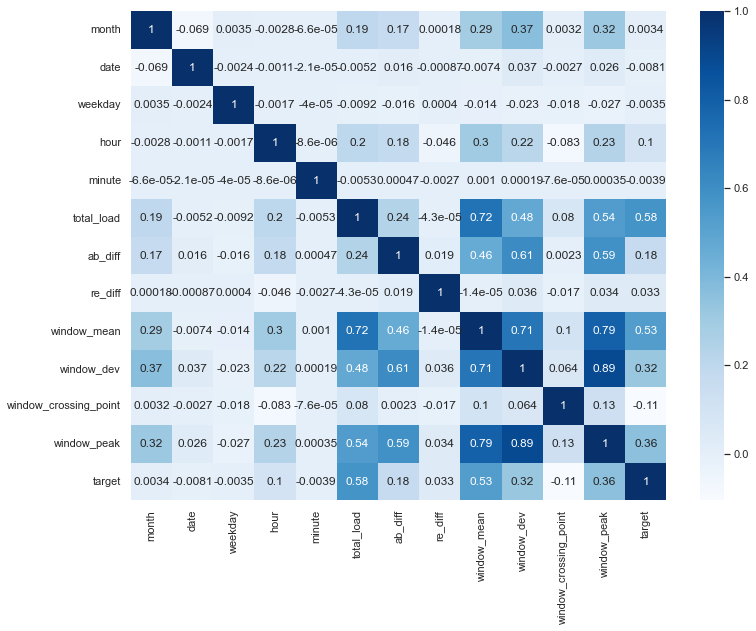

In [5]:
c = train_normal.corr()

sns.set(rc={'figure.figsize':(12,9)})

sns.heatmap(c, cmap="Blues", annot=True)

In [6]:
top = c.iloc[:, -1:].reindex(c.target.abs().sort_values(ascending = False).index).iloc[1:, :]
top_features = top.index.to_list()
top

,target
total_load,0.576940
window_mean,0.529645
window_peak,0.357295
window_dev,0.324742
ab_diff,0.175344
window_crossing_point,-0.105124
hour,0.100808
re_diff,0.033362
date,-0.008135
minute,-0.003857


# Test

In [7]:
train_y = train_normal.target
train_x = train_normal.drop('target', axis = 1)

train_x = train_x.drop('month', axis = 1)

# convert dates to categorical
train_x['date'] = train_x['date'].astype('category')
train_x['weekday'] = train_x['weekday'].astype('category')
train_x['hour'] = train_x['hour'].astype('category')
train_x['minute'] = train_x['minute'].astype('category')

train_x = pd.get_dummies(train_x)

In [8]:
feature_a = train.iloc[:,0:7].columns.to_list()
feature_b = train.iloc[:,8:-1].columns.to_list()
normal_standard = ColumnTransformer([('standardscaler', StandardScaler(), feature_a)], 
                                    remainder='passthrough')
normal_minmax = ColumnTransformer([('minmaxscaler', MinMaxScaler(), feature_b)], 
                                  remainder='passthrough')

test = pd.read_csv("./test_data_nolabels.csv")

# transform test data

# get dataid
test_id = test.dataid

# change type from string to datetime object
test.localminute = pd.to_datetime(test.localminute)

# create new columns
test['date'] = test.localminute.dt.day
test['weekday'] = test.localminute.dt.weekday
test['hour'] = test.localminute.dt.hour
test['minute'] = test.localminute.dt.minute

# remove localminute and dataid column
test = test.drop(['dataid', 'localminute'], axis = 1)

col_names = test.columns

# normalise test data
test = pd.DataFrame(normal_standard.fit_transform(test))
# rename columns
test.columns = col_names
# do the rest
test = pd.DataFrame(normal_minmax.fit_transform(test))
# rename columns
test.columns = feature_b + feature_a

# select test columns
#test = test[features]

# convert dates to categorical
test['date'] = test['date'].astype('category')
test['weekday'] = test['weekday'].astype('category')
test['hour'] = test['hour'].astype('category')
test['minute'] = test['minute'].astype('category')

test = pd.get_dummies(test)

In [9]:
lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)

lr_test = lr_model.predict(test).astype('int')

lr_final = pd.DataFrame({"dataid" : test_id, "target" : lr_test})
lr_final.to_csv("lr_result.csv", index = False)
print(lr_final.target.value_counts())

0    98458
1     6494
Name: target, dtype: int64


In [12]:
k_model = KNeighborsClassifier(n_neighbors = 1, algorithm = "kd_tree").fit(train_x, train_y)

k_test = k_model.predict(test).astype('int')

k_final = pd.DataFrame({"dataid" : test_id, "target" : k_test})
k_final.to_csv("k_result.csv", index = False)
print(k_final.target.value_counts())

0    100154
1      4798
Name: target, dtype: int64


In [20]:
rf_model = RandomForestClassifier(max_depth = 18, random_state=0).fit(train_x, train_y)

rf_test = rf_model.predict(test).astype('int')

rf_final = pd.DataFrame({"dataid" : test_id, "target" : rf_test})
rf_final.to_csv("rf_result.csv", index = False)
print(rf_final.target.value_counts())

0    99805
1     5147
Name: target, dtype: int64
